In [1]:
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

/Users/sagar/Desktop/work/Personal/Projects/AI Assisted 3D Design Optimization/point-e/point-e-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# print('creating base model...')
# base_name = 'base40M-textvec'
# base_model = model_from_config(MODEL_CONFIGS[base_name], device)
# base_model.eval()
# base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

# print('creating upsample model...')
# upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
# upsampler_model.eval()
# upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

# print('downloading base checkpoint...')
# base_model.load_state_dict(load_checkpoint(base_name, device))

# print('downloading upsampler checkpoint...')
# upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...


100%|██████████| 161M/161M [01:43<00:00, 1.56MiB/s] 
/Users/sagar/Desktop/work/Personal/Projects/AI Assisted 3D Design Optimization/point-e/point_e/models/download.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any iss

downloading upsampler checkpoint...


<All keys matched successfully>

In [3]:
# # Save the base model checkpoint
# torch.save(base_model.state_dict(), 'base_model_text2pointcloud_checkpoint.pth')

# # Save the upsampler model checkpoint
# torch.save(upsampler_model.state_dict(), 'upsampler_model_text2pointcloud_checkpoint.pth')

# print("Models have been saved successfully.")


Models have been saved successfully.


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the models
base_model = model_from_config(MODEL_CONFIGS['base40M-textvec'], device)
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)

# Set models to evaluation mode
base_model.eval()
upsampler_model.eval()


# Reload base model from the saved checkpoint
base_model.load_state_dict(torch.load('base_model_text2pointcloud_checkpoint.pth', map_location=device))

# Reload upsampler model from the saved checkpoint
upsampler_model.load_state_dict(torch.load('upsampler_model_text2pointcloud_checkpoint.pth', map_location=device))

print("Models have been loaded from saved files.")


Models have been loaded from saved files.


/var/folders/lg/c5lydbls6wg1gj53ggzbvqtr0000gn/T/ipykernel_69560/1956798926.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load('base_

In [31]:
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['base40M-textvec'])
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

### slow method

In [32]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

# #faster
# sampler = PointCloudSampler(
#     device=device,
#     models=[base_model, upsampler_model],
#     diffusions=[base_diffusion, upsampler_diffusion],
#     num_points=[512, 1024 - 512],
#     aux_channels=['R', 'G', 'B'],
#     guidance_scale=[2.0, 0.0],
#     model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
# )


# #even faster
# sampler = PointCloudSampler(
#     device=device,
#     models=[base_model],
#     diffusions=[base_diffusion],
#     num_points=[512],
#     aux_channels=['R', 'G', 'B'],
#     guidance_scale=[2.0, 0.0],
#     model_kwargs_key_filter=('texts'), # Do not condition the upsampler at all
# )

In [33]:
attributes = [attr for attr in dir(base_diffusion) if not attr.startswith('_')]
print(attributes)

['alphas_cumprod', 'alphas_cumprod_next', 'alphas_cumprod_prev', 'betas', 'calc_bpd_loop', 'channel_biases', 'channel_scales', 'condition_mean', 'condition_score', 'ddim_reverse_sample', 'ddim_sample', 'ddim_sample_loop', 'ddim_sample_loop_progressive', 'discretized_t0', 'get_sigmas', 'log_one_minus_alphas_cumprod', 'loss_type', 'model_mean_type', 'model_var_type', 'num_timesteps', 'p_mean_variance', 'p_sample', 'p_sample_loop', 'p_sample_loop_progressive', 'posterior_log_variance_clipped', 'posterior_mean_coef1', 'posterior_mean_coef2', 'posterior_variance', 'q_mean_variance', 'q_posterior_mean_variance', 'q_sample', 'scale_channels', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'sqrt_recip_alphas_cumprod', 'sqrt_recipm1_alphas_cumprod', 'training_losses', 'unscale_channels', 'unscale_out_dict']


In [34]:
base_diffusion.num_timesteps, upsampler_diffusion.num_timesteps

(1024, 1024)

In [35]:
# Set a prompt to condition on.
prompt = 'a red motorcycle'

# # Produce a sample from the model.
# samples = None
# for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
#     samples = x



max_steps = 50  # Limit to 50 steps
samples = None
for step, x in enumerate(tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt])))):
    samples = x  # Store the latest sample
    if step >= max_steps:
        break

print("Sampling completed.")

50it [00:48,  1.02it/s]

Sampling completed.


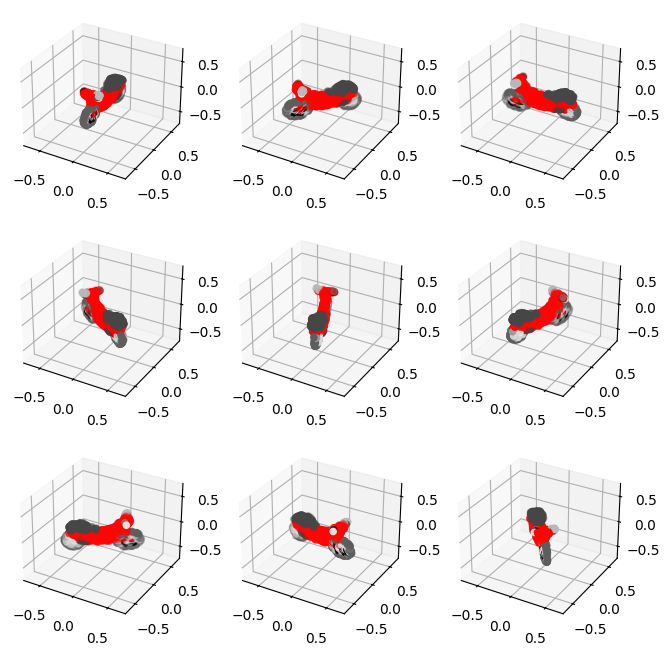

In [36]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [37]:
pc

PointCloud(coords=array([[ 0.00057602, -0.28796527,  0.01718565],
       [-0.09636347, -0.31537756,  0.2452598 ],
       [-0.06076535,  0.28383365, -0.07557854],
       ...,
       [ 0.03726943, -0.2670597 ,  0.2165938 ],
       [ 0.05220503,  0.27158034, -0.10201228],
       [-0.01177235,  0.3185351 , -0.26295447]], dtype=float32), channels={'R': array([0.7647059 , 1.        , 0.28235295, ..., 1.        , 0.2784314 ,
       0.3647059 ], dtype=float32), 'G': array([0.7647059 , 0.01960784, 0.25882354, ..., 0.01568628, 0.25882354,
       0.36862746], dtype=float32), 'B': array([0.7647059 , 0.01960784, 0.2627451 , ..., 0.01568628, 0.2627451 ,
       0.3647059 ], dtype=float32)})

In [42]:
import numpy as np
from point_e.util.ply_util import write_ply

# Extract coordinates and RGB channels
coords = pc.coords  # Shape: [N, 3]
R = pc.channels['R']
G = pc.channels['G']
B = pc.channels['B']

# Combine R, G, B into a single [N x 3] array
rgb = np.stack([R, G, B], axis=1)  # Shape: [N, 3]


In [43]:
# Open the file in binary write mode and save the point cloud
with open("output_pointcloud.ply", "wb") as f:
    write_ply(f, coords=coords, rgb=rgb)

print("Point cloud saved as .ply")


Point cloud saved as .ply


In [44]:
np.savez("output_pointcloud.npz", coords=coords, rgb=rgb)
print("Point cloud saved as .npz")

Point cloud saved as .npz
